<a href="https://colab.research.google.com/github/kainspraveen/Local-Global-Attention-Network/blob/main/hybrid_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!nvidia-smi

Sun Oct 31 14:29:50 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.29.05    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
#decompress

!unzip "/content/drive/My Drive/train_y_list.npy.zip"
!unzip "/content/drive/MyDrive/covid_lung.zip"
!unzip "/content/drive/My Drive/chest_ct_scan.zip"

!unzip "/content/drive/My Drive/test_y_list.npy.zip"
!unzip "/content/drive/MyDrive/ISBI2016_ISIC_Part3_Test_Data.zip"

!unzip "/content/drive/My Drive/skin-lesion-segmentation.zip"
!unzip "/content/drive/MyDrive/ISBI2016_ISIC_Part3_Training_Data.zip"
!unzip "/content/drive/MyDrive/ISBI2016_ISIC_Part3_Training_GroundTruth.csv.zip"
!unzip "/content/drive/MyDrive/ISBI2016_ISIC_Part1_Training_GroundTruth.zip"
!unzip "/content/drive/MyDrive/ISBI2016_ISIC_Part1_Test_GroundTruth.zip"
!unzip "/content/drive/MyDrive/ISBI2016_ISIC_Part1_Test_Data.zip"
!unzip "/content/drive/MyDrive/ISBI2016_ISIC_Part3_Test_GroundTruth.csv.zip"

Streaming output truncated to the last 5000 lines.
  inflating: ISBI2016_ISIC_Part3_Training_Data/ISIC_0001306.jpg  
  inflating: __MACOSX/ISBI2016_ISIC_Part3_Training_Data/._ISIC_0001306.jpg  
  inflating: ISBI2016_ISIC_Part3_Training_Data/ISIC_0011115.jpg  
  inflating: __MACOSX/ISBI2016_ISIC_Part3_Training_Data/._ISIC_0011115.jpg  
  inflating: ISBI2016_ISIC_Part3_Training_Data/ISIC_0000018.jpg  
  inflating: __MACOSX/ISBI2016_ISIC_Part3_Training_Data/._ISIC_0000018.jpg  
  inflating: ISBI2016_ISIC_Part3_Training_Data/ISIC_0010223.jpg  
  inflating: __MACOSX/ISBI2016_ISIC_Part3_Training_Data/._ISIC_0010223.jpg  
  inflating: ISBI2016_ISIC_Part3_Training_Data/ISIC_0000030.jpg  
  inflating: __MACOSX/ISBI2016_ISIC_Part3_Training_Data/._ISIC_0000030.jpg  
  inflating: ISBI2016_ISIC_Part3_Training_Data/ISIC_0010237.jpg  
  inflating: __MACOSX/ISBI2016_ISIC_Part3_Training_Data/._ISIC_0010237.jpg  
  inflating: ISBI2016_ISIC_Part3_Training_Data/ISIC_0000024.jpg  
  inflating: __MACOSX/ISB

In [ ]:
#imports
from __future__ import division
import tensorflow as tf
import numpy as np
import pandas as pd
from PIL import Image
import PIL as pil
import random
import os
from copy import deepcopy
from matplotlib import pyplot as plt
import skimage
import os
import skimage.io as io
import skimage.transform as trans
import numpy as np
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import backend as keras
from tensorflow.keras.utils import plot_model
import os
from tensorflow.keras.optimizers import SGD
from numpy import asarray
import matplotlib.image as mpimg
from skimage import color
from tensorflow.keras import backend as K
from skimage import io
import sys
from time import time
from time import sleep
import datetime
from scipy.stats import zscore
from sklearn.utils import shuffle
from IPython.display import display
from IPython.display import Image as _Imgdis

from scipy import ndimage
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img


np.set_printoptions(threshold=sys.maxsize)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ['CUDA_VISIBLE_DEVICES'] = "0"

sample images: 


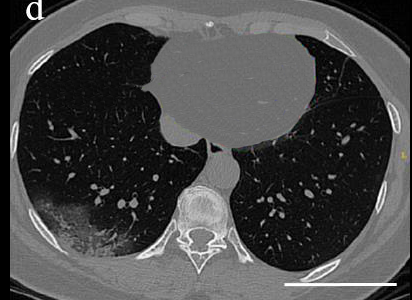

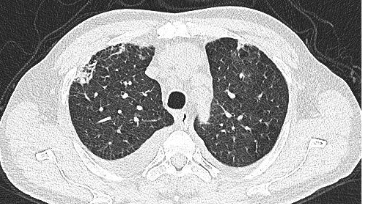


(120, 160, 3)
Total number of COVID images added :  746
shape:  (746, 120, 160, 3)


In [ ]:
import math
#INPUT OF COVID DATASET
train_images=[]
covid_images=[]

# 1 for COVID positive
# 0 for COVID negative
covid_labels=[]   
combined_covid_labels=[]
ultimate_covid_labels=[]
folder="covid_lung/CT_COVID"
onlyfiles = [f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]
l1=len(onlyfiles)


print("sample images: ")
for i in range(2):
    display(_Imgdis(filename=folder + "/" + onlyfiles[i], width=240, height=320))
    print()


for _file in onlyfiles:
    img=Image.open("covid_lung/CT_COVID/"+_file).convert('L').convert('RGB')
    img=img.resize((160,120))
    img=np.array(img)
    #print(img.ndim)

    train_images.append(img)
    covid_labels.append(1)
    combined_covid_labels.append(np.array([0,1,0,0,0,0]))
    ultimate_covid_labels.append(np.array([0,1,0,0,0,0,0,0]))

#print("Number of covid images added : ", len(train_images))

folder="covid_lung/CT_NonCOVID"
onlyfiles = [f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]
l2=len(onlyfiles)

for _file in onlyfiles:
    img=Image.open("covid_lung/CT_NonCOVID/"+_file).convert('L').convert('RGB')
    img=img.resize((160,120))
    img=np.array(img)
    train_images.append(img)
    covid_labels.append(0)
    combined_covid_labels.append(np.array([0,0,1,0,0,0]))
    ultimate_covid_labels.append(np.array([0,0,1,0,0,0,0,0]))




image_width = 640
image_height = 480
ratio = 4

image_width = int(image_width / ratio)
image_height = int(image_height / ratio)
channels = 3
#print("**&*",train_images[0].shape)
list_covid_images=deepcopy(train_images)
covid_images = np.ndarray(shape=(len(train_images), image_height, image_width, channels),dtype=np.float32)
i=0
print(covid_images[0].shape)
for j in train_images:
    #print(j.shape)
    covid_images[i]=j
    i+=1

print("Total number of COVID images added : ", len(covid_images))
print("shape: ",covid_images.shape)
combined_covid_images=covid_images
#print(covid_images[0])
#print(covid_labels)
covid_labels=np.array(covid_labels)
#covid_images,covid_labels=shuffle(covid_images,covid_labels)

no_of_classes=1







###############################################################################################################################################################################
###############################################################################################################################################################################
###############################################################################################################################################################################
###############################################################################################################################################################################
###############################################################################################################################################################################















sample images: 


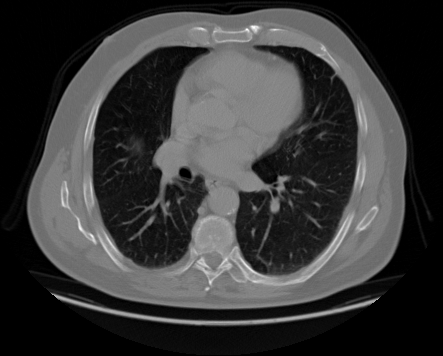

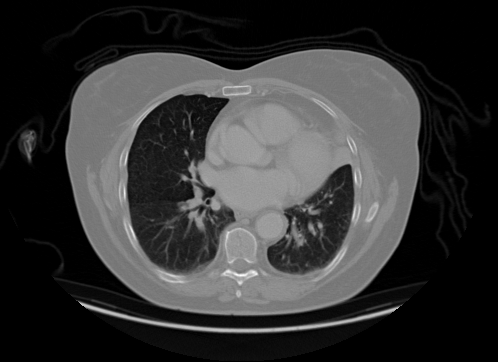


Total number of Chest images added :  1000
shape:  (1000, 120, 160, 3)
len of labels 1000


In [ ]:
#INPUT OF CHEST CT SCAN DATASET
train_images=[]
chest_images=[]

# 1 for adenocarcinoma
# 2 for large cell carcinoma
# 3 for squamous cell carcinoma
# 0 for normal
chest_labels=[]
combined_chest_labels=[]
ultimate_chest_labels=[]

folder="chest_ct_scan/test/adenocarcinoma"
onlyfiles = [f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]
l1=len(onlyfiles)


print("sample images: ")
for i in range(2):
    display(_Imgdis(filename=folder + "/" + onlyfiles[i], width=240, height=320))
    print()


for _file in onlyfiles:
    img=Image.open(folder+"/"+_file).convert('L').convert('RGB')
    img=img.resize((160,120))
    img=np.array(img)
    train_images.append(img)
    chest_labels.append(np.array([0,1,0,0]))
    combined_chest_labels.append(np.array([0,0,0,1,0,0]))
    ultimate_chest_labels.append(np.array([0,0,0,1,0,0,0,0]))



folder="chest_ct_scan/test/large.cell.carcinoma"
onlyfiles = [f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]
l2=len(onlyfiles)

for _file in onlyfiles:
    img=Image.open(folder+"/"+_file).convert('L').convert('RGB')
    img=img.resize((160,120))
    img=np.array(img)
    train_images.append(img)
    chest_labels.append(np.array([0,0,1,0]))
    combined_chest_labels.append(np.array([0,0,0,0,1,0]))
    ultimate_chest_labels.append(np.array([0,0,0,0,1,0,0,0]))

folder="chest_ct_scan/test/squamous.cell.carcinoma"
onlyfiles = [f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]
l2=len(onlyfiles)

for _file in onlyfiles:
    img=Image.open(folder+"/"+_file).convert('L').convert('RGB')
    img=img.resize((160,120))
    img=np.array(img)
    train_images.append(img)
    chest_labels.append(np.array([0,0,0,1]))
    combined_chest_labels.append(np.array([0,0,0,0,0,1]))
    ultimate_chest_labels.append(np.array([0,0,0,0,0,1,0,0]))

folder="chest_ct_scan/test/normal"
onlyfiles = [f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]
l2=len(onlyfiles)

for _file in onlyfiles:
    img=Image.open(folder+"/"+_file).convert('L').convert('RGB')
    img=img.resize((160,120))
    img=np.array(img)
    train_images.append(img)
    chest_labels.append(np.array([1,0,0,0]))
    combined_chest_labels.append(np.array([1,0,0,0,0,0]))
    ultimate_chest_labels.append(np.array([1,0,0,0,0,0,0,0]))


################################################################################
#train set


folder="/content/chest_ct_scan/train/adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib"
onlyfiles = [f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]
l1=len(onlyfiles)

for _file in onlyfiles:
    img=Image.open(folder+"/"+_file).convert('L').convert('RGB')
    img=img.resize((160,120))
    img=np.array(img)
    train_images.append(img)
    chest_labels.append(np.array([0,1,0,0]))
    combined_chest_labels.append(np.array([0,0,0,1,0,0]))
    ultimate_chest_labels.append(np.array([0,0,0,1,0,0,0,0]))


folder="/content/chest_ct_scan/train/large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa"
onlyfiles = [f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]
l2=len(onlyfiles)

for _file in onlyfiles:
    img=Image.open(folder+"/"+_file).convert('L').convert('RGB')
    img=img.resize((160,120))
    img=np.array(img)
    train_images.append(img)
    chest_labels.append(np.array([0,0,1,0]))
    combined_chest_labels.append(np.array([0,0,0,0,1,0]))
    ultimate_chest_labels.append(np.array([0,0,0,0,1,0,0,0]))

folder="/content/chest_ct_scan/train/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa"
onlyfiles = [f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]
l2=len(onlyfiles)

for _file in onlyfiles:
    img=Image.open(folder+"/"+_file).convert('L').convert('RGB')
    img=img.resize((160,120))
    img=np.array(img)
    train_images.append(img)
    chest_labels.append(np.array([0,0,0,1]))
    combined_chest_labels.append(np.array([0,0,0,0,0,1]))
    ultimate_chest_labels.append(np.array([0,0,0,0,0,1,0,0]))

folder="/content/chest_ct_scan/train/normal"
onlyfiles = [f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]
l2=len(onlyfiles)

for _file in onlyfiles:
    img=Image.open(folder+"/"+_file).convert('L').convert('RGB')
    img=img.resize((160,120))
    img=np.array(img)
    train_images.append(img)
    chest_labels.append(np.array([1,0,0,0]))
    combined_chest_labels.append(np.array([1,0,0,0,0,0]))
    ultimate_chest_labels.append(np.array([1,0,0,0,0,0,0,0]))



################################################################################
#evaluation set


folder="/content/chest_ct_scan/valid/adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib"
onlyfiles = [f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]
l1=len(onlyfiles)



for _file in onlyfiles:
    img=Image.open(folder+"/"+_file).convert('L').convert('RGB')
    img=img.resize((160,120))
    img=np.array(img)
    train_images.append(img)
    chest_labels.append(np.array([0,1,0,0]))
    combined_chest_labels.append(np.array([0,0,0,1,0,0]))
    ultimate_chest_labels.append(np.array([0,0,0,1,0,0,0,0]))



folder="/content/chest_ct_scan/valid/large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa"
onlyfiles = [f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]
l2=len(onlyfiles)

for _file in onlyfiles:
    img=Image.open(folder+"/"+_file).convert('L').convert('RGB')
    img=img.resize((160,120))
    img=np.array(img)
    train_images.append(img)
    chest_labels.append(np.array([0,0,1,0]))
    combined_chest_labels.append(np.array([0,0,0,0,1,0]))
    ultimate_chest_labels.append(np.array([0,0,0,0,1,0,0,0]))

folder="/content/chest_ct_scan/valid/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa"
onlyfiles = [f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]
l2=len(onlyfiles)

for _file in onlyfiles:
    img=Image.open(folder+"/"+_file).convert('L').convert('RGB')
    img=img.resize((160,120))
    img=np.array(img)
    train_images.append(img)
    chest_labels.append(np.array([0,0,0,1]))
    combined_chest_labels.append(np.array([0,0,0,0,0,1]))
    ultimate_chest_labels.append(np.array([0,0,0,0,0,1,0,0]))

folder="/content/chest_ct_scan/valid/normal"
onlyfiles = [f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]
l2=len(onlyfiles)

for _file in onlyfiles:
    img=Image.open(folder+"/"+_file).convert('L').convert('RGB')
    img=img.resize((160,120))
    img=np.array(img)
    train_images.append(img)
    chest_labels.append(np.array([1,0,0,0]))
    combined_chest_labels.append(np.array([1,0,0,0,0,0]))
    ultimate_chest_labels.append(np.array([1,0,0,0,0,0,0,0]))

#################################################################################









image_width = 640
image_height = 480
ratio = 4

image_width = int(image_width / ratio)
image_height = int(image_height / ratio)
channels = 3

chest_images = np.ndarray(shape=(len(train_images), image_height, image_width, channels),dtype=np.float32)
i=0
for j in train_images:
    chest_images[i]=j
    i+=1
print("Total number of Chest images added : ", len(chest_images))
print("shape: ",chest_images.shape)
combined_chest_images=chest_images
chest_labels=np.array(chest_labels)
chest_images,chest_labels=shuffle(chest_images,chest_labels)
print("len of labels",len(chest_labels))

sample images: 


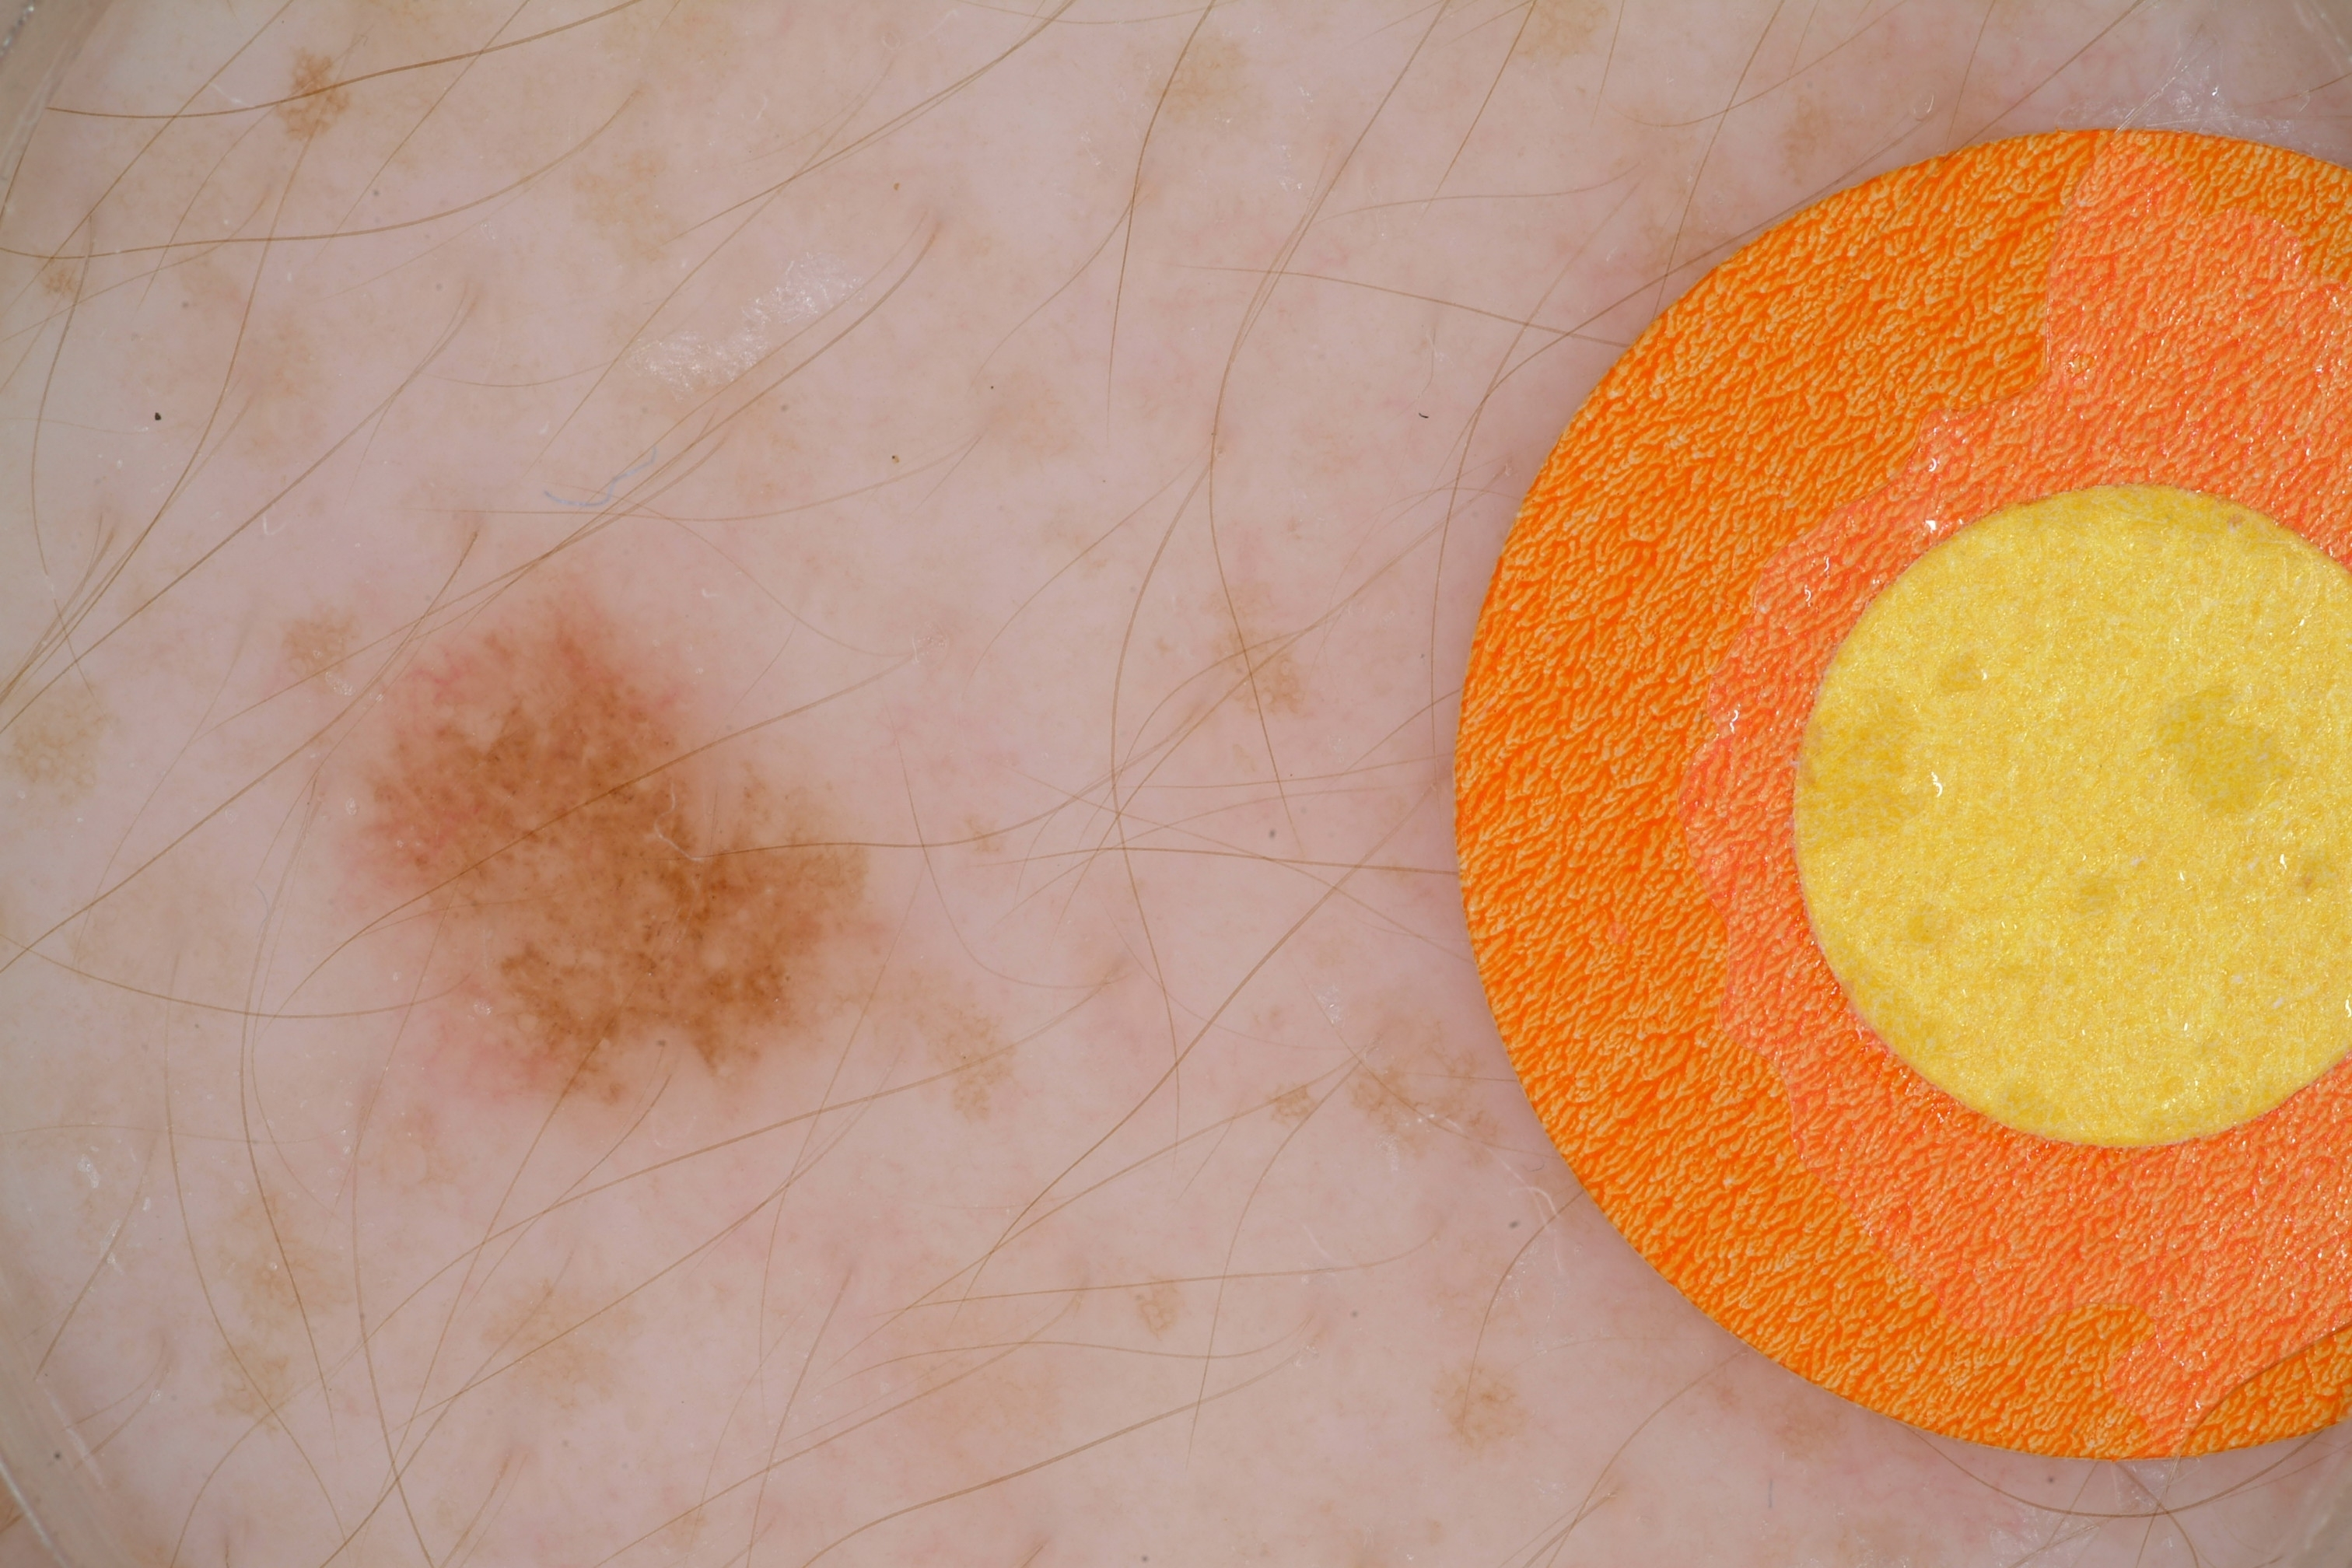

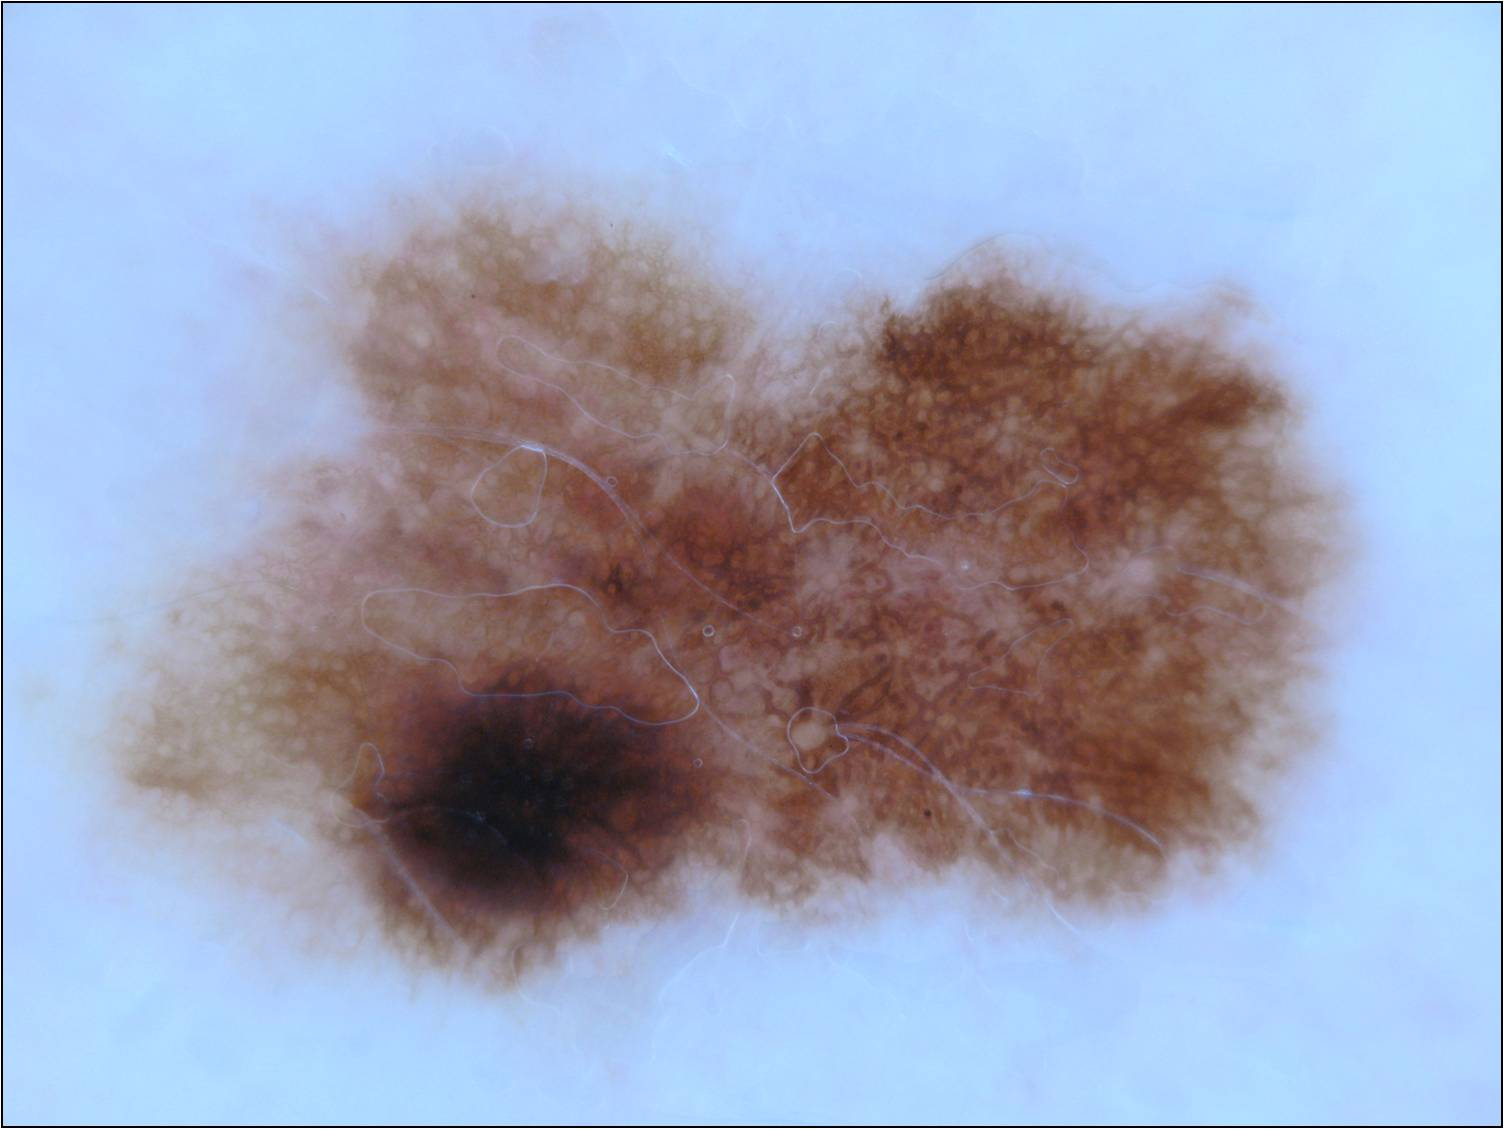

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(120, 160, 3)
Total number of melanoma images added :  1279
shape:  (1279, 120, 160, 3)
shape:  (900,)
shape:  (379,)
*****************************************************************


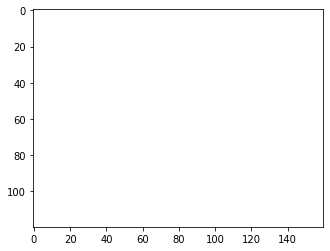

In [ ]:
#input for isic malanoma data
train_images=[]
melanoma_images=[]


mel_train_labels=np.load('train_y_list.npy')
mel_test_labels=np.load('test_y_list.npy')


folder='/content/ISBI2016_ISIC_Part3_Training_Data'
onlyfiles = [f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]
l1=len(onlyfiles)


print("sample images: ")
for i in range(2):
    display(_Imgdis(filename=folder + "/" + onlyfiles[i], width=240, height=320))
    print()


for _file in onlyfiles:
    img=Image.open("/content/ISBI2016_ISIC_Part3_Training_Data/"+_file).convert('L').convert('RGB')
    img=img.resize((160,120))
    img=np.array(img)
    #print(img.ndim)

    train_images.append(img)
    

#print("Number of covid images added : ", len(train_images))

folder='/content/ISBI2016_ISIC_Part3_Test_Data'
onlyfiles = [f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]
l1=len(onlyfiles)

for _file in onlyfiles:
    img=Image.open("/content/ISBI2016_ISIC_Part3_Test_Data/"+_file).convert('L').convert('RGB')
    img=img.resize((160,120))
    img=np.array(img)
    #print(img.ndim)

    train_images.append(img)



image_width = 640
image_height = 480
ratio = 4

image_width = int(image_width / ratio)
image_height = int(image_height / ratio)
channels = 3
#print("**&*",train_images[0].shape)
melanoma_images = np.ndarray(shape=(len(train_images), image_height, image_width, channels),dtype=np.float32)
i=0
print(melanoma_images[0].shape)
for j in train_images:
    #print(j.shape)
    melanoma_images[i]=j
    i+=1

print("Total number of melanoma images added : ", len(melanoma_images))
print("shape: ",melanoma_images.shape)
print("shape: ",mel_train_labels.shape)
print("shape: ",mel_test_labels.shape)




    






combined_mel_images=melanoma_images
combined_mel_labels=[]
print("*****************************************************************")
plt.imshow(melanoma_images[0],interpolation=None)
plt.show()
#print(covid_images[0])
#print(covid_labels)
mel_train_labels=np.array(mel_train_labels)
ultimate_mel_labels=[]
for i in mel_train_labels:
    if(i==1):
        ultimate_mel_labels.append(np.array([0,0,0,0,0,0,1,0]))
        combined_mel_labels.append([0,1])
    else:
        ultimate_mel_labels.append(np.array([0,0,0,0,0,0,0,1]))
        combined_mel_labels.append([1,0])

for i in mel_test_labels:
    if(i==1):
        ultimate_mel_labels.append(np.array([0,0,0,0,0,0,1,0]))
        combined_mel_labels.append([0,1])
    else:
        ultimate_mel_labels.append(np.array([0,0,0,0,0,0,0,1]))
        combined_mel_labels.append(np.array([1,0]))
ultimate_mel_labels=np.array(ultimate_mel_labels)
melanoma_images,ultimate_mel_labels=shuffle(melanoma_images,ultimate_mel_labels)
combined_mel_labels=np.array(combined_mel_labels)




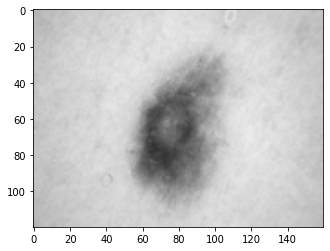

255.0


In [ ]:
plt.imshow(melanoma_images[0]/255, interpolation = None)
plt.show()
print(melanoma_images.max())


In [ ]:
#alternative block for combined run
#1covid positive.              [0,1,0,0,0,0]
#2covid negative.              [0,0,1,0,0,0]
#3 for adenocarcinoma.         [0,0,0,1,0,0]
#4 for large cell carcinoma.   [0,0,0,0,1,0]
#5 for squamous cell carcinoma,[0,0,0,0,0,1]
#0 for normal chest.           [1,0,0,0,0,0]

#for covid data
print("******",len(combined_covid_images))
for i in range(len(combined_covid_images)):
            combined_covid_images[i]=combined_covid_images[i].astype('float64')
            mean, std = combined_covid_images[i].mean(), combined_covid_images[i].std()
            combined_covid_images[i]=(combined_covid_images[i]-mean)/std

#for chest
for i in range(len(combined_chest_images)):
            combined_chest_images[i]=combined_chest_images[i].astype('float64')
            mean, std = combined_chest_images[i].mean(), combined_chest_images[i].std()
            combined_chest_images[i]=(combined_chest_images[i]-mean)/std

combined_data=np.ndarray(shape=(len(combined_covid_images)+len(combined_chest_images), image_height, image_width, channels),dtype=np.float32)
combined_labels=np.ndarray(shape=(len(combined_covid_images)+len(combined_chest_images),6))

i=0
k=0
for j in combined_covid_images:
    combined_data[i]=j
    combined_labels[i]=combined_covid_labels[k]
    i+=1
    k+=1
k=0
for j in combined_chest_images:
    combined_data[i]=j
    combined_labels[i]=combined_chest_labels[k]
    i+=1
    k+=1

combined_data,combined_labels=shuffle(combined_data,combined_labels)
print(combined_data.shape)
#print(combined_data[0])
print(combined_labels.shape)

****** 746
(1746, 120, 160, 3)
(1746, 6)


(3025, 120, 160, 3)
(3025, 8)


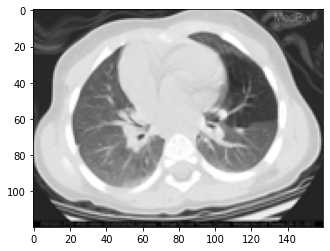

x_train :  (2420, 120, 160, 3)
x_test :  (605, 120, 160, 3)
y_train :  (2420,)
y_test :  (605,)


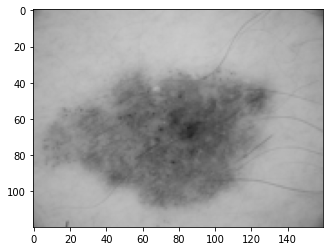

max min :  255 0


In [ ]:
#alternative block for combined run including melanoma

#alternative block for combined run
#1covid positive.               [0,1,0,0,0,0,0,0]
#2covid negative.               [0,0,1,0,0,0,0,0]
#3 for adenocarcinoma.          [0,0,0,1,0,0,0,0]
#4 for large cell carcinoma.    [0,0,0,0,1,0,0,0]
#5 for squamous cell carcinoma, [0,0,0,0,0,1,0,0]
#0 for normal chest.            [1,0,0,0,0,0,0,0]
#6 malignanat melanoma.         [0,0,0,0,0,0,1,0]
#7 benign melanoma              [0,0,0,0,0,0,0,1]

"""
#for covid data
for i in range(len(combined_covid_images)):
            combined_covid_images[i]=combined_covid_images[i].astype('float64')
            mean, std = combined_covid_images[i].mean(), combined_covid_images[i].std()
            combined_covid_images[i]=(combined_covid_images[i]-mean)/std

#for chest
for i in range(len(combined_chest_images)):
            combined_chest_images[i]=combined_chest_images[i].astype('float64')
            mean, std = combined_chest_images[i].mean(), combined_chest_images[i].std()
            combined_chest_images[i]=(combined_chest_images[i]-mean)/std

#for melanoma

for i in range(len(combined_mel_images)):
            combined_mel_images[i]=combined_mel_images[i].astype('float64')
            mean, std = combined_mel_images[i].mean(), combined_mel_images[i].std()
            combined_mel_images[i]=(combined_mel_images[i]-mean)/std

"""
ultimate_data=np.ndarray(shape=(len(combined_covid_images)+len(combined_chest_images)+len(combined_mel_images), image_height, image_width, channels),dtype=np.float32)
ultimate_labels=np.ndarray(shape=(len(combined_covid_images)+len(combined_chest_images)+len(combined_mel_images),8), dtype = np.int32)

i=0
k=0
for j in combined_covid_images:
    ultimate_data[i]=j
    ultimate_labels[i]=ultimate_covid_labels[k]
    i+=1
    k+=1
k=0
for j in combined_chest_images:
    ultimate_data[i]=j
    ultimate_labels[i]=ultimate_chest_labels[k]
    i+=1
    k+=1
k=0
for j in combined_mel_images:
    ultimate_data[i]=j
    ultimate_labels[i]=ultimate_mel_labels[k]
    i+=1
    k+=1

ultimate_data,ultimate_labels=shuffle(ultimate_data,ultimate_labels)
print(ultimate_data.shape)
print(ultimate_labels.shape)


plt.imshow(ultimate_data[-1][:,:,0]/250, cmap='gray')
plt.show()



x_train = ultimate_data[:int(3025*0.8)].astype('int32')
x_test = ultimate_data[int(3025*0.8):].astype('int32')
y_train = ultimate_labels[:2420]
y_test = ultimate_labels[2420:]

y_train = y_train.argmax(axis=1)
y_test = y_test.argmax(axis=1)
print("x_train : ", x_train.shape)
print("x_test : ", x_test.shape )
print("y_train : ", y_train.shape)
print("y_test : ", y_test.shape)
plt.imshow(x_train[-1]/250, cmap='gray')
plt.show()

print("max min : ", x_train.max(), x_train.min())


In [ ]:
#model
input_size=(120,160,3)

inputs = Input(shape=input_size)
conv1 = Conv2D(16, 5, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
conv2 = Conv2D(16, 5, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
#conv3 = Conv2D(4, 5, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv2)
drop1=Dropout(0.4)(pool1)
conv4 = Conv2D(64, 5, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(drop1)
conv5 = Conv2D(64, 5, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
#conv6 = Conv2D(4, 5, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)

pool2 = MaxPooling2D(pool_size=(2, 2))(conv5)
drop2 = Dropout(0.4)(pool2)
conv7 = Conv2D(128, 5, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(drop2)
conv8 = Conv2D(128, 5, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)
#conv9 = Conv2D(4, 5, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv8)

drop3 = Dropout(0.4)(pool3)
conv9 = Conv2D(128, 5, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(drop3)
conv10 = Conv2D(128, 5, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
#conv9 = Conv2D(4, 5, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
pool4 = MaxPooling2D(pool_size=(2, 2))(conv10)

"""drop4 = Dropout(0.2)(pool4)
conv11 = Conv2D(128, 5, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(drop4)
conv12 = Conv2D(128, 5, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv11)
#conv9 = Conv2D(4, 5, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
pool5 = MaxPooling2D(pool_size=(2, 2))(conv12)"""


#drop3 = Dropout(0.1)(pool3)
flat=Flatten()(pool4)
fc1=Dense(1024,activation="relu")(flat)

fc2=Dense(512,activation="relu")(fc1)
fc4=Dense(1,activation="sigmoid")(fc2)


model=Model(inputs,fc4)

model.compile(optimizer = Adam(lr = 1e-6), loss = 'binary_crossentropy', metrics = ['accuracy',tf.keras.metrics.Precision(),tf.keras.metrics.Recall(),tf.keras.metrics.AUC()])
plot_model(model, to_file="classification_model.png", show_shapes=True)
model.summary()


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Model: "model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, 120, 160, 3)]     0         
_________________________________________________________________
conv2d_120 (Conv2D)          (None, 120, 160, 16)      1216      
_________________________________________________________________
conv2d_121 (Conv2D)          (None, 120, 160, 16)      6416      
_________________________________________________________________
max_pooling2d_60 (MaxPooling (None, 60, 80, 16)        0         
_________________________________________________________________
dropout_45 (Dropout)         (None, 60, 80, 16)        0         
_________________________________________________________________
conv2d_122 (Conv2D)          (None, 60, 80, 64)        25664     
_________________________________________________________________
conv2d_123 (Conv2D)          (None, 60, 80, 64)        102

# Progressive Fusion for Medical Image

In [ ]:
!pip install tensorflow-addons

     |████████████████████████████████| 1.1 MB 4.2 MB/s 


x_train shape:  (2420, 120, 160, 3)
x_test shape:  (605, 120, 160, 3)
y_train shape :  (2420,)
y_test shape :  (605,)
Image size: 160 X 160
Patch size: 8 X 8
Patches per image: 400
Elements per patch: 192


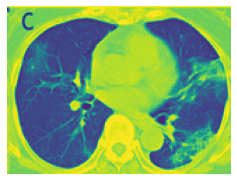

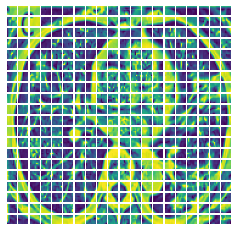

In [ ]:
#Vi-Transformer Implementation
from tensorflow import keras
import pandas as pd
import numpy as np
from tensorflow.keras import layers
import tensorflow_addons as tfa
import tensorflow as tf

#Example for CIFAR-100

num_classes=8
input_shape=(120,160,3)

#(x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data()


print("x_train shape: ", x_train.shape)
print("x_test shape: ", x_test.shape)
print("y_train shape : ", y_train.shape)
print("y_test shape : ", y_test.shape)


#Configure Hyper Parameters
lr=1e-2
weight_decay= 1e-3
batch_size=256
num_epochs=100
image_size=160 #resize images (32,32,3) to (72,72,3)
patch_size=8
num_patches = (image_size//patch_size)**2
projection_dim=128
num_heads=8


transformer_units=[projection_dim*2, projection_dim ] #size of transformer layer

transformer_layers=8
mlp_head_units=[2048, 1024]


#Data Augmentation as Keras Layer

data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip('horizontal'),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(height_factor=0.2, width_factor=0.2)
     
    ],
    name='data_augmentation'
)

data_augmentation.layers[0].adapt(x_train)


#MLP (Multi Layer Perceptron)
def mlp(x, hidden_units, dropout):
    for units in hidden_units:
        x=layers.Dense(units, activation=tf.nn.gelu)(x)
        x=layers.Dropout(dropout)(x)
    return x

#patch Creation as Layer

class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size=patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides = [1, self.patch_size, self.patch_size, 1],
            rates= [1,1,1,1],
            padding= 'VALID'
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1,patch_dims])
        return patches


#display patches for an image
from matplotlib import pyplot as plt
plt.figure(figsize=(4,4))
image=x_train[np.random.choice(range(x_train.shape[0]))]
#image=x_train[2021]

plt.imshow(image[:,:,0])
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)

patches=Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")



n=int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4,4))

for i, patch in enumerate(patches[0]):
    
    ax=plt.subplot(n,n,i+1)
    patch_img=tf.reshape(patch, (patch_size, patch_size, 3))
    #print(patch_img)
    #break
    plt.imshow(patch_img.numpy()[:,:,0].astype('int32'))
    plt.axis('off')

#pacth encoding Layer

class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches=num_patches
        self.projection=layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim =num_patches, output_dim = projection_dim
        )
        print(type(self.position_embedding))

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch)+self.position_embedding(positions)
        return encoded


#build the Vi-T model

#consists of multiple transformer blocks

def create_vit_classifier():

    inputs=layers.Input(shape=input_shape)


    #augment data
    augmented = data_augmentation(inputs)
    #create patches
    patches = Patches(patch_size)(augmented)

    #encode patches
    temp=PatchEncoder(num_patches,projection_dim)(patches)
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)
    #create multiple layrs of the transformer block

    for _ in range(transformer_layers):
        #layer normalization
        x1=layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        attention_output=layers.MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim, dropout=0.1)(x1,x1)
        #skip connection 1
        x2=layers.Add()([attention_output, encoded_patches])
        #layer normalization 2

        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        x3 = mlp(x3, hidden_units=transformer_units, dropout=0.1)
        #skip connection 2
        encoded_patches = layers.Add()([x3, x2])

    #create a [batch_size, projection_dim] tensor

    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)

    #add mlp

    #features = mlp(representation, hidden_units=mlp_head_units, dropout=0.5)
    #classify outputs

    #logits = layers.Dense(num_classes)(features)

    model = keras.Model(inputs=inputs, outputs = representation)
    return model

    


<class 'keras.layers.embeddings.Embedding'>
<class 'keras.layers.embeddings.Embedding'>
<class 'keras.layers.embeddings.Embedding'>
<class 'keras.layers.embeddings.Embedding'>
<class 'keras.layers.embeddings.Embedding'>
Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_24 (InputLayer)           [(None, 120, 160, 3) 0                                            
__________________________________________________________________________________________________
input_23 (InputLayer)           [(None, 120, 160, 3) 0                                            
__________________________________________________________________________________________________
data_augmentation (Sequential)  (None, 160, 160, 3)  7           input_23[0][0]                   
                                                                 inpu

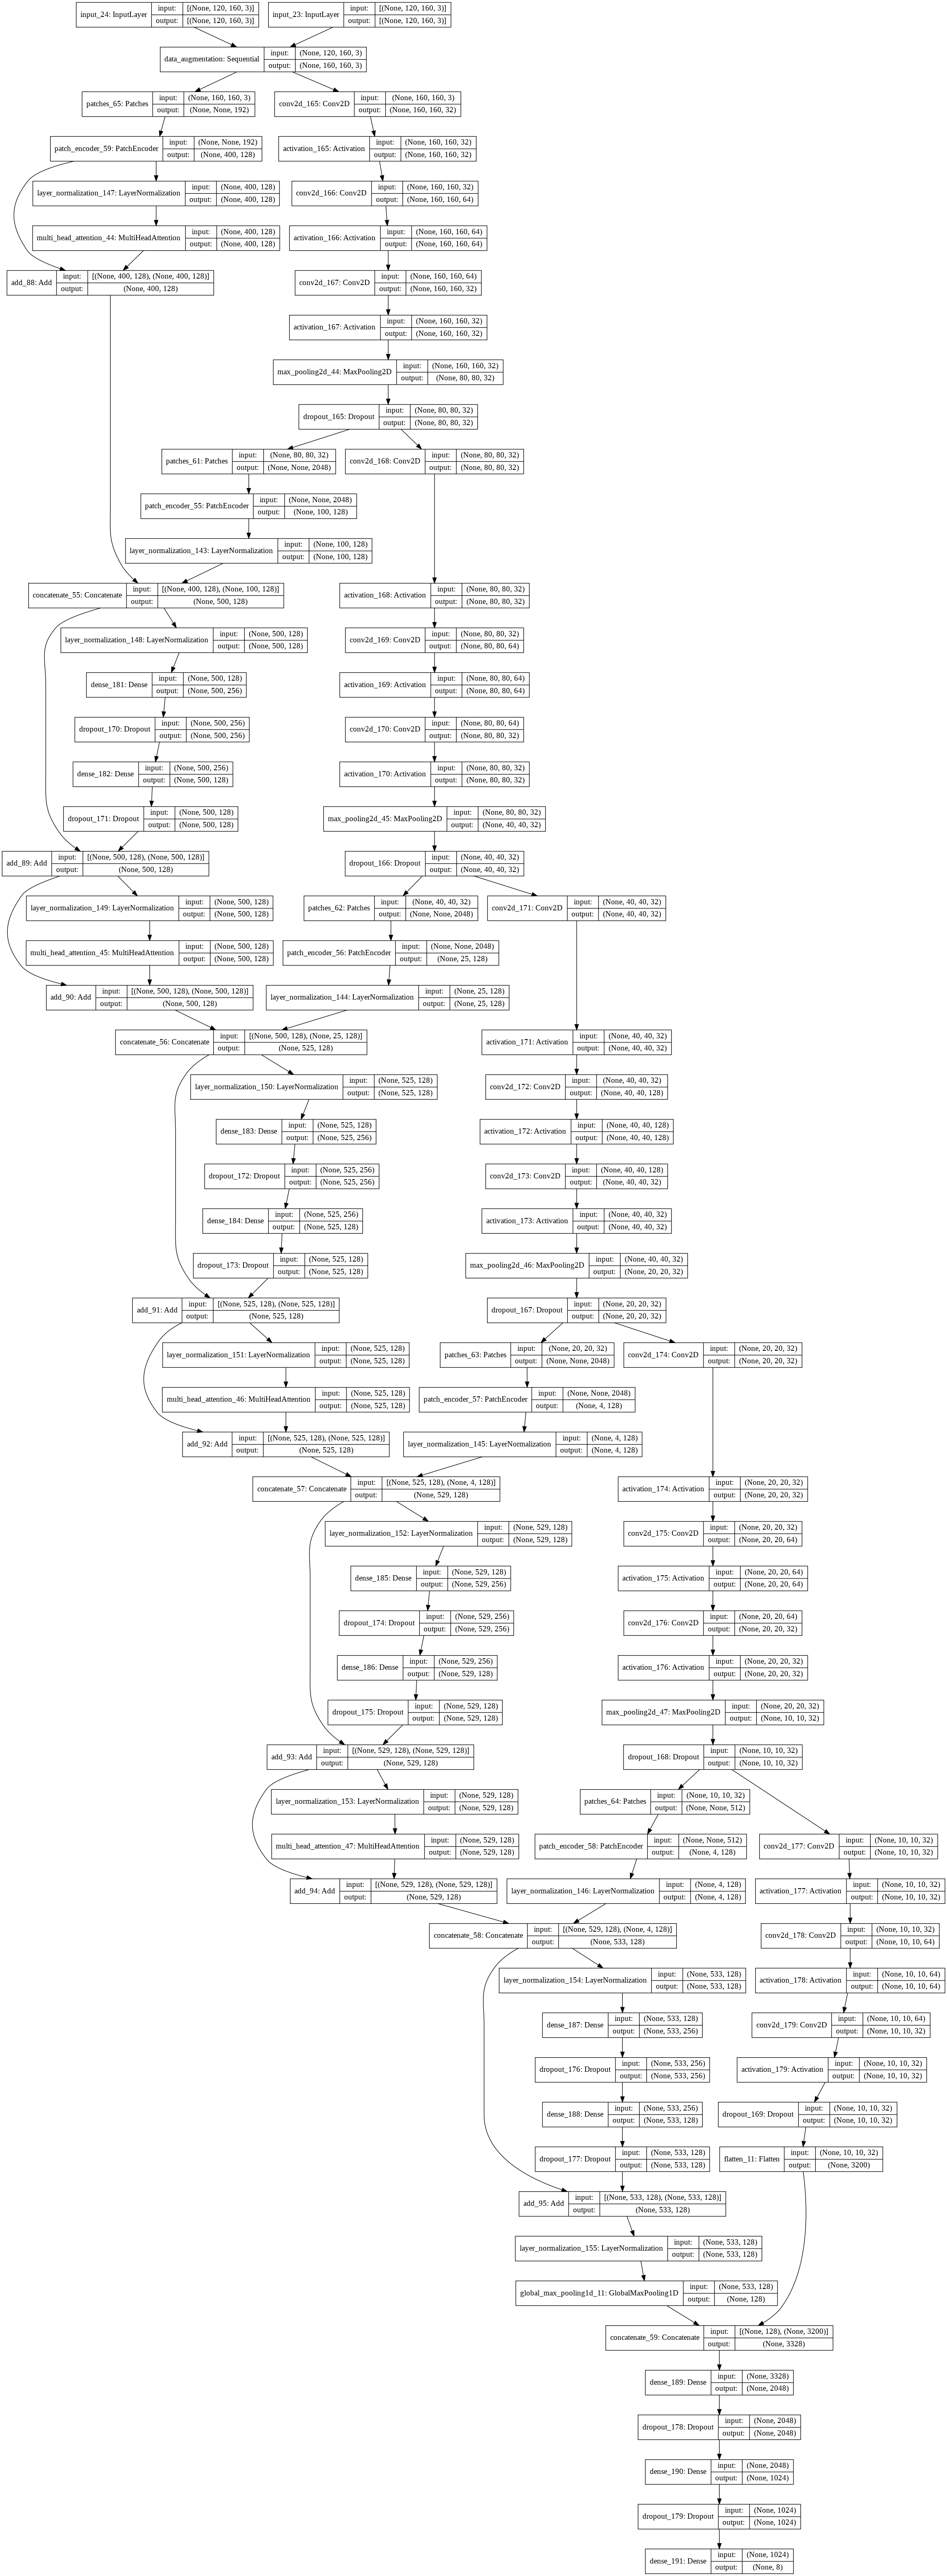

In [ ]:
#Progressive Fusion Model
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.layers import Dense, GlobalMaxPooling2D, Conv2D, MaxPooling2D, Dropout, Add, LayerNormalization, Flatten, AveragePooling2D, BatchNormalization, GlobalMaxPooling1D
from tensorflow.keras.utils import plot_model

from tensorflow.keras import layers
from tensorflow.keras import activations



def progressive_fusion():
    input_size=(120,160,3)
    inputs = keras.layers.Input(shape=input_size)
    augmented = data_augmentation(inputs)

    dic={}


    conv1 = Conv2D(32, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(augmented)
    #batch=BatchNormalization(epsilon=1e-6)(conv1)
    batch=layers.Activation(activations.relu)(conv1)
    conv2 = Conv2D(64, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(batch)
    #batch=BatchNormalization(epsilon=1e-6)(conv2)
    batch=layers.Activation(activations.relu)(conv2)
    conv2 = Conv2D(32, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(batch)
    #batch=BatchNormalization(epsilon=1e-6)(conv2)
    batch=layers.Activation(activations.relu)(conv2)
    #conv3 = Conv2D(32, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(batch)
    #batch=BatchNormalization(epsilon=1e-6)(conv3)
    #batch=layers.Activation(activations.relu)(conv3)
    #skip=Add()([conv1, batch])

    pool1 = MaxPooling2D(pool_size=(2, 2), padding='same')(batch)
    #x1=LayerNormalization(epsilon=1e-6)(pool1)
    drop1=Dropout(0)(pool1)

    patches_1 = Patches(patch_size)(drop1)
    patch_encoder_1 = PatchEncoder((80//patch_size)**2, projection_dim)(patches_1)
    norm1 = layers.LayerNormalization(epsilon=1e-6)(patch_encoder_1)
    dic['patch_encoder1']=norm1





    conv4 = Conv2D(32, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(drop1)
    #batch=BatchNormalization(epsilon=1e-6)(conv4)
    batch=layers.Activation(activations.relu)(conv4)
    conv2 = Conv2D(64, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(batch)
    #batch=BatchNormalization(epsilon=1e-6)(conv2)
    batch=layers.Activation(activations.relu)(conv2)
    conv5 = Conv2D(32, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(batch)
    #batch=BatchNormalization(epsilon=1e-6)(conv5)
    batch=layers.Activation(activations.relu)(conv5)
    #conv6 = Conv2D(32, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(batch)
    #batch=BatchNormalization(epsilon=1e-6)(conv6)
    #batch=layers.Activation(activations.relu)(conv6)
    #skip=Add()([conv4, batch])

    pool2 = MaxPooling2D(pool_size=(2, 2), padding='same')(batch)
    #x2=LayerNormalization(epsilon=1e-6)(pool2)
    drop2 = Dropout(0)(pool2)

    patches_2 = Patches(patch_size)(drop2)
    patch_encoder_2 = PatchEncoder((40//patch_size)**2, projection_dim)(patches_2)
    norm2 = layers.LayerNormalization(epsilon=1e-6)(patch_encoder_2)
    dic['patch_encoder2']=norm2



    conv7 = Conv2D(32, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(drop2)
    #batch=BatchNormalization(epsilon=1e-6)(conv7)
    batch=layers.Activation(activations.relu)(conv7)
    conv2 = Conv2D(128, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(batch)
    #batch=BatchNormalization(epsilon=1e-6)(conv2)
    batch=layers.Activation(activations.relu)(conv2)
    conv8 = Conv2D(32, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(batch)
    #batch=BatchNormalization(epsilon=1e-6)(conv8)
    batch=layers.Activation(activations.relu)(conv8)
    #conv9 = Conv2D(32, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(batch)
    #batch=BatchNormalization(epsilon=1e-6)(conv9)
    #batch=layers.Activation(activations.relu)(conv9)

    #skip=Add()([conv7, batch])
    pool3 = MaxPooling2D(pool_size=(2, 2), padding='same')(batch)
    #x3=LayerNormalization(epsilon=1e-6)(pool3)
    drop3 = Dropout(0)(pool3)

    patches_3 = Patches(patch_size)(drop3)
    patch_encoder_3 = PatchEncoder((20//(patch_size))**2, projection_dim)(patches_3)
    norm3 = layers.LayerNormalization(epsilon=1e-6)(patch_encoder_3)
    dic['patch_encoder3']=norm3





    conv9 = Conv2D(32, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(drop3)
    #batch=BatchNormalization(epsilon=1e-6)(conv9)
    batch=layers.Activation(activations.relu)(conv9)
    conv2 = Conv2D(64, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(batch)
    #batch=BatchNormalization(epsilon=1e-6)(conv2)
    batch=layers.Activation(activations.relu)(conv2)
    conv10 = Conv2D(32, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(batch)
    #batch=BatchNormalization(epsilon=1e-6)(conv10)
    batch=layers.Activation(activations.relu)(conv10)
    #conv11 = Conv2D(32, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(batch)
    #batch=BatchNormalization(epsilon=1e-6)(conv11)
    #batch=layers.Activation(activations.relu)(conv11)
    #skip=Add()([conv9, batch])
    pool4 = MaxPooling2D(pool_size=(2, 2), padding='same')(batch)
    #x4=LayerNormalization(epsilon=1e-6)(pool4)
    drop4 = Dropout(0)(pool4)

    patches_4 = Patches(patch_size//2)(drop4)
    #print("patches_4 shape ", patches_4.shape)
    patch_encoder_4 = PatchEncoder((10//(patch_size//2))**2, projection_dim)(patches_4)
    #print("PAtch_encoder_4 input, output : ", patch_encoder.input_shape, patch_encoder.output_shape)
    norm4 = layers.LayerNormalization(epsilon=1e-6)(patch_encoder_4)
    dic['patch_encoder4']=norm4





    conv11 = Conv2D(32, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(drop4)
    #batch=BatchNormalization(epsilon=1e-6)(conv11)
    batch=layers.Activation(activations.relu)(conv11)
    conv2 = Conv2D(64, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(batch)
    #batch=BatchNormalization(epsilon=1e-6)(conv2)
    batch=layers.Activation(activations.relu)(conv2)
    conv12 = Conv2D(32, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(batch)
    #batch=BatchNormalization(epsilon=1e-6)(conv12)
    batch=layers.Activation(activations.relu)(conv12)
    #conv13 = Conv2D(32, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(batch)
    #batch=BatchNormalization(epsilon=1e-6)(conv13)
    #batch=layers.Activation(activations.relu)(conv13)

    #skip=Add()([conv11, batch])
    #x5=LayerNormalization(epsilon=1e-6)(skip)
    #pool5=MaxPooling2D(pool_size=(2,2))(x5)
    drop4 = Dropout(0)(batch)

    

    """conv11 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(drop4)
    conv12 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv11)
    conv13 = Conv2D(4, 5, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv12)

    pool4 = MaxPooling2D(pool_size=(2, 2))(conv13)
    drop4 = Dropout(0.2)(pool4)

    conv11 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(drop4)
    conv12 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv11)
    conv13 = Conv2D(4, 5, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv12)

    pool4 = MaxPooling2D(pool_size=(2, 2))(conv13)
    drop4 = Dropout(0.2)(pool4)

    conv11 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(drop4)
    conv12 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv11)
    conv13 = Conv2D(4, 5, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv12)
    pool5 = MaxPooling2D(pool_size=(2, 2))(conv13)"""

    #x = drop4
    x=layers.Flatten()(drop4)
    #x=layers.Dense(2048, activation='relu')(x)
    #x=layers.Dense(100, activation='relu')(x)
    






    inputs_trans=layers.Input(shape=input_shape)
    #augment data
    augmented_1 = data_augmentation(inputs_trans)
    #create patches
    patches = Patches(patch_size)(augmented_1)

    #encode patches
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)
    #create multiple layrs of the transformer block



    for i in range(transformer_layers-4): #to match cnn blocks = 5
        #layer normalization
        x1=layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        attention_output=layers.MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim, dropout=0.2)(x1,x1)
        #skip connection 1
        x2=layers.Add()([attention_output, encoded_patches])
        #layer normalization 2
        #print("Add Shape : ", x2.shape)
        #print("patch_encoder from cnn shape : ", dic['patch_encoder'+str(i+1)].shape)
        x2 = layers.Concatenate(axis = 1)([x2, dic['patch_encoder'+str(i+1)]])

        #print("concatenate shape : ", x2.shape)

        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        x3 = mlp(x3, hidden_units=transformer_units, dropout=0)
        #skip connection 2
        #print("mlp xhape : ", x3.shape)
        encoded_patches = layers.Add()([x3, x2])
        #print("encoded_patches : ", encoded_patches.shape)
        #print("\n\n\n")

    #create a [batch_size, projection_dim] tensor
    #print(encoded_patches.shape)
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    #print(representation.shape)
    representation = layers.GlobalMaxPool1D()(representation)
    #print(representation.shape)
    #representation = layers.Dropout(0.2)(representation)
    #representation = layers.Dense(2048, activation='relu')(representation)
    #representation = layers.Dense(100, activation='relu')(representation)


    #print(representation.shape)
    combined=layers.Concatenate()([representation, x])
    #combined = layers.Normalization()(combined)
    #print(combined.shape)
    #combined = layers.GlobalAveragePooling1D()(combined)
    combined=mlp(combined, hidden_units=[2048, 1024], dropout=0)
    logits=Dense(8)(combined)



    #add mlp

    #features = mlp(representation, hidden_units=mlp_head_units, dropout=0.5)
    #classify outputs

    #logits = layers.Dense(num_classes)(features)

    model = keras.Model(inputs=[inputs_trans, inputs] , outputs = logits)
    return model



progressive_model = progressive_fusion()
progressive_model.summary()


progressive_model.compile(optimizer=tf.optimizers.Adam(learning_rate= 5e-4), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")] )
plot_model(progressive_model, to_file="new_model.png", show_shapes=True)

In [ ]:
#training
#print(combined_mel_images.shape)
print("\n\n\n......................................TRAINING STARTS ............................................\n")
#callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=3,restore_best_weights=True)
#history=model.fit(chest_images[:800],chest_labels[:800],epochs=150,verbose=1)
history=progressive_model.fit([x_train, x_train],y_train, validation_data=([x_test, x_test], y_test), epochs=150,verbose=1)
#history=model.fit(chest_images[:250],chest_labels[:250],epochs=1000,verbose=1)
#history=model.fit(combined_data[:1400],combined_labels[:1400],epochs=300,verbose=1)
#history=model.fit(ultimate_data[:2420],ultimate_labels[:2420],epochs=200,verbose=1)





......................................TRAINING STARTS ............................................

Epoch 1/150
76/76 [==============================] - 47s 512ms/step - loss: 1.0787 - acc: 0.5690 - val_loss: 0.8524 - val_acc: 0.6380
Epoch 2/150
76/76 [==============================] - 39s 520ms/step - loss: 0.8691 - acc: 0.6236 - val_loss: 0.7836 - val_acc: 0.6826
Epoch 3/150
76/76 [==============================] - 40s 526ms/step - loss: 0.7910 - acc: 0.6694 - val_loss: 0.7996 - val_acc: 0.6760
Epoch 4/150
76/76 [==============================] - 41s 535ms/step - loss: 0.7516 - acc: 0.6901 - val_loss: 0.8086 - val_acc: 0.6628
Epoch 5/150
76/76 [==============================] - 41s 545ms/step - loss: 0.7243 - acc: 0.7000 - val_loss: 0.7044 - val_acc: 0.6860
Epoch 6/150
76/76 [==============================] - 42s 547ms/step - loss: 0.6550 - acc: 0.7364 - val_loss: 0.8299 - val_acc: 0.6876
Epoch 7/150
76/76 [==============================] - 42s 554ms/step - loss: 0.6466 - acc: 0.7

KeyboardInterrupt: ignored

In [ ]:
plt.plot(history.history['acc'],color='red')
plt.plot(history.history['val_acc'], color = 'blue')
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_acc', 'val_acc'])
plt.show()




plt.plot(history.history['loss'],color='red')
plt.plot(history.history['val_loss'], color ='blue')
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

NameError: ignored

In [ ]:
#confusion matrix 
#progressive_model.load_weights("/content/drive/MyDrive/cnn-trans-fusion-16-sep-5pm/checkpoint104-val_acc:0.584/")
print(y_test.shape)
y_pred=progressive_model.predict([x_test, x_test])

#1covid positive.               [0,1,0,0,0,0,0,0]
#2covid negative.               [0,0,1,0,0,0,0,0]
#3 for adenocarcinoma.          [0,0,0,1,0,0,0,0]
#4 for large cell carcinoma.    [0,0,0,0,1,0,0,0]
#5 for squamous cell carcinoma, [0,0,0,0,0,1,0,0]
#0 for normal chest.            [1,0,0,0,0,0,0,0]
#6 malignanat melanoma.         [0,0,0,0,0,0,1,0]
#7 benign melanoma




classes = ['Covid +ve', 'Covid -ve', 'Adenocarcinoma', 'large-cell', 'squamou-cell', 'normal-chest', 'malignant-mel', 'benign-mel']
y_pred = y_pred.argmax(axis=1)


(605,)


(605,)
(605,)
(605,)


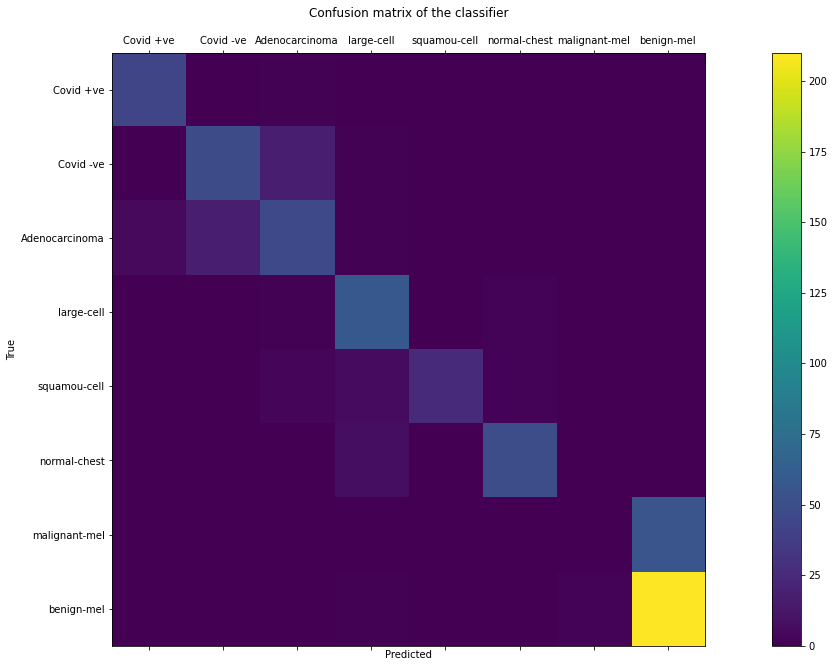

                precision    recall  f1-score   support

     Covid +ve    0.89796   0.97778   0.93617        45
     Covid -ve    0.72727   0.71642   0.72180        67
Adenocarcinoma    0.66667   0.65714   0.66187        70
    large-cell    0.77333   0.95082   0.85294        61
  squamou-cell    1.00000   0.69444   0.81967        36
  normal-chest    0.92593   0.86207   0.89286        58
 malignant-mel    0.00000   0.00000   0.00000        55
    benign-mel    0.79245   0.98592   0.87866       213

      accuracy                        0.79504       605
     macro avg    0.72295   0.73057   0.72050       605
  weighted avg    0.72971   0.79504   0.75586       605



In [ ]:
from sklearn import metrics
from matplotlib import pyplot as plt
print(y_pred.shape)
#print(y_pred.argmax(axis=1).shape)


print(y_pred.shape)
#y_pred = y_pred.reshape((10000,1))

print(y_pred.shape)
cm = metrics.confusion_matrix(y_test, y_pred)
fig = plt.figure(figsize=(24,24))
ax = fig.add_subplot(211)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + classes)
ax.set_yticklabels([''] + classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print(metrics.classification_report(y_test, y_pred, target_names=classes, digits=5))

In [ ]:
#resnet50 

from keras.applications.resnet50 import ResNet50
from keras.layers import Dense, GlobalAveragePooling2D
base_model = ResNet50(include_top=False, weights='imagenet')
x = base_model.output
x = GlobalMaxPooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(512,activation='relu')(x)
predictions = Dense(2, activation='softmax')(x)
model2 = Model(inputs=base_model.input, outputs=predictions)
for layer in base_model.layers:
    layer.trainable = False
model2.compile(optimizer=SGD(lr=0.0001), loss='binary_crossentropy', metrics = ['accuracy',tf.keras.metrics.Precision(),tf.keras.metrics.Recall(),tf.keras.metrics.AUC()])
model2.summary()


#history2=model2.fit(ultimate_data[:2420],ultimate_labels[:2420],epochs=350,verbose=1)
history2=model2.fit(combined_mel_images[:800],combined_mel_labels[:800],epochs=350,verbose=1)

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, None, None, 6 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [ ]:
#evaluation

model.evaluate(covid_images[520:747],covid_labels[520:747])
#model.evaluate(chest_images[800:],chest_labels[800:])
#model.evaluate(combined_data[1400:],combined_labels[1400:])
#model.evaluate(combined_data[850:1062],combined_labels[850:1062])
#model.evaluate(ultimate_data[2420:],ultimate_labels[2420:])
#model2.evaluate(ultimate_data[2420:],ultimate_labels[2420:])
#model2.evaluate(covid_images[520:],covid_labels[520:])
#model2.evaluate(chest_images[800:],chest_labels[800:])

8/8 [==============================] - 1s 44ms/step - loss: 0.6400 - accuracy: 0.6062 - precision_15: 0.0000e+00 - recall_15: 0.0000e+00 - auc_15: 0.0000e+00


[0.6399887800216675, 0.6061946749687195, 0.0, 0.0, 0.0]

In [ ]:
#results 
plt.plot(history.history['accuracy'],color='red')
plt.plot(history2.history['accuracy'],color='blue')
plt.title('Accuracy')
plt.legend(['CNN','ResNet50'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.savefig("model_acc_graph.png")
plt.show()
plt.plot(history.history['loss'],color='red')
plt.plot(history2.history['loss'],color='blue')
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['CNN','ResNet50'])
plt.savefig("model_loss_graph.png")
plt.show()




Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


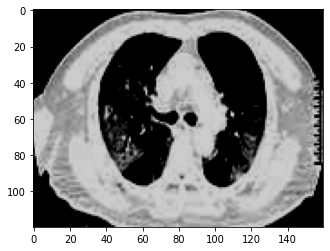

In [ ]:
img=covid_images[0]
plt.imshow(img,interpolation=None)
plt.show()